In [4]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, PolynomialModel
from lmfit import Parameter
from LineClass import REDUC_LINES
%matplotlib widget

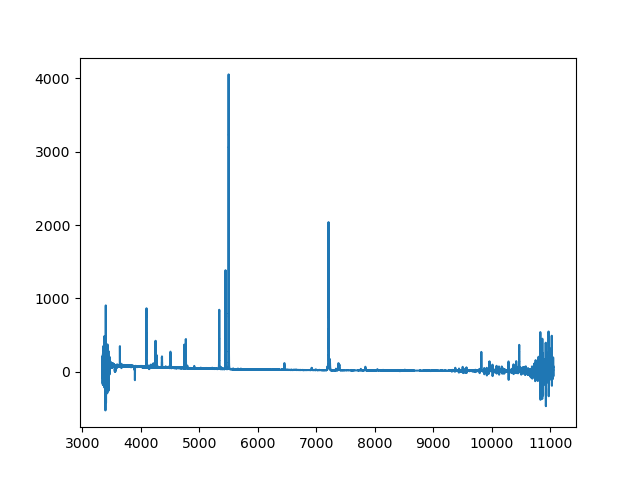

In [33]:
import pandas as pd

J0021 = pd.read_csv('/Users/javieratoro/Desktop/proyecto 2024-2/nava_data/analogs/specs/final_spec/J0021.csv')
plt.close()
plt.step(J0021['wave'].values, J0021['flux'].values/1e-17)
plt.show()


In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import datetime
import numpy as np
import pandas as pd
from GaussianFitting import fitSpectrum, fitSpectrumMC
from scipy.ndimage import gaussian_filter1d


class REDUC_LINES:
    def __init__(self, SPECTRA):
        self.SPECTRA = SPECTRA
        self.DIR = SPECTRA['DIR']
        self.FILES = SPECTRA['FILES']
        self.redshift = SPECTRA['redshift']
        self.names = SPECTRA['names']
        self.mass = SPECTRA['mass']
        self.MC_unc = None
        self.init = None
        path = '/Users/javieratoro/Desktop/proyecto 2024-2/CSV_files/emission_lines.csv'
        self.line_list = pd.read_csv(path)
        self.line_name = self.line_list['name']
        self.line_wave_or = self.line_list['vacuum_wave']
        self.lines_waves = self.line_list['vacuum_wave']*(1 + self.redshift)
        self.new_spectra = None

        linelist_table = ascii.read(path)
        self.linelist_dict = {}
        for line in linelist_table:
            self.linelist_dict[line['name']] = line['vacuum_wave']

        print(f'Using directory : {self.DIR}')
        self.hdus = []
        self.datas = []

        self.zs = []
        for i in self.FILES:
            path = SPECTRA['DIR'] + i
            hdu = fits.open(path)
            self.hdus.append(hdu)
            mask = (hdu[1].data['wave'] > 3650)
            data = []
            data.append(hdu[1].data['wave'][mask])
            data.append(hdu[1].data['flux'][mask])
            data.append(hdu[1].data['sigma'][mask])
            data.append(i.partition("/")[0])
            self.datas.append(data)

            self.reset_redshift(data)

        self.redshift = np.median(self.zs)
        self.lines_waves = self.line_list['vacuum_wave']*(1 + self.redshift)

    def reset_redshift(self, data):
        wavelength, flux, _, name = data
        lines = ['O3_5008', 'H_alpha']
        zs = []
        for line in lines:
            or_wave = self.line_wave_or[self.line_name == line].values
            wave_O3 = self.lines_waves[self.line_name == line].values
            mask = ((wavelength > wave_O3 - 150) &
                    (wavelength < wave_O3 + 150))
            wave = wavelength[mask]
            fluxes = flux[mask]
            peak_index = np.argmax(fluxes)
            peak_wavelength = wave[peak_index]
            z = (peak_wavelength / or_wave) - 1
            zs.append(z)
        print(f'New calculated redshift for {name},  z = {np.median(zs)}')
        self.redshift = np.median(zs)
        self.zs.append(zs)


    def balmer_absorption(self, showplot=False):
        balmer_lines = ['H_alpha', 'H_beta', 'H_gamma', 'H_delta',
                        'H_epsilon', 'H_6', 'H_7', 'H_8', 'H_9', 'H_10', 'H_11']

        seps = [(2, 2), (5, 5), (10, 10)]
        wave1, flux1, _, _ = self.datas[0]
        self.new_spectra = flux1.copy()
        stamps = []
        comps = []

        def get_center_and_sep(label):
            """Return the center and separation value based on the label."""
            center = self.linelist_dict[label] * (1 + self.redshift)

            if label == 'H_alpha':
                center_N2 = self.linelist_dict['N2_6585'] * (1 + self.redshift)
                center_N1 = self.linelist_dict['N2_6550'] * (1 + self.redshift)
                sep = 2.5 * (center_N2 - center_N1)
            elif label in ['H_8', 'H_9', 'H_10', 'H_11']:
                center_H2 = self.linelist_dict['H_8'] * (1 + self.redshift)
                center_H1 = self.linelist_dict['H_9'] * (1 + self.redshift)
                sep = 1.2 * (center_H2 - center_H1)
            else:
                center_2 = self.linelist_dict['H_epsilon'] * (1 + self.redshift)
                center_1 = self.linelist_dict['Ne3_3868'] * (1 + self.redshift)
                sep = 1.35 * (center_2 - center_1)
            return center, sep

        for label in balmer_lines:
            center, sep = get_center_and_sep(label)

            lamb = wave1[(wave1 < center+sep) & (wave1 > center-sep)]
            flux2 = flux1[(wave1 < center+sep) & (wave1 > center-sep)]


            if 'alpha' in label or 'beta' in label:
                mask = (wave1 < center+seps[2][0]) & (wave1 > center-seps[2][1])
            elif not any(char.isdigit() for char in label) and not ('alpha' in label or 'beta' in label):
                mask = (wave1 < center+seps[1][0]) & (wave1 > center-seps[1][1])
            else:
                mask = (wave1 < center+seps[0][0]) & (wave1 > center-seps[0][1])

            new_flux = flux1.copy()

            if label=='H_10' or label =='H_11':
                new_flux[flux1 > 10] =  np.nan
            else:
                new_flux[flux1 > 10] = np.nan

            new_flux[mask] = np.min(flux2)
            new_flux = new_flux[(wave1 < center+sep) & (wave1 > center-sep)]

            narrow_gaussians = GaussianModel(prefix=label+'_narrow_')

            polydeg = 1
            polynomial = PolynomialModel(degree=polydeg)

            comp_mult = narrow_gaussians + polynomial
            pars_mult = comp_mult.make_params()


            pars_mult.add(name='z', value=self.redshift)
            min_v = 250 if label in ['H_6', 'H_9', 'H_10', 'H_11'] else 300
            max_v = 2000 if label == 'H_alpha' else 500
            guess = 500 if label == 'H_alpha' else 350
            pars_mult.add(name='sigma_v_narrow', value=guess, min=min_v, max=max_v)

            lam = self.linelist_dict[label]
            for param in ['center', 'amplitude', 'sigma']:
                narrow_key = f'{label}_narrow_{param}'
                if param == 'center':
                    value = lam
                    vary = False
                    min_ = None
                    max_ = None
                    expr = f'{lam:6.2f}*(1+z)'
                elif param == 'amplitude':
                    value = 1
                    vary = True
                    min_ = -100
                    max_ = 0
                    expr = None
                elif param == 'sigma':
                    vary = True
                    min_ = None
                    max_ = None
                    expr = f'(sigma_v_narrow/3e5)*{label}_narrow_center'
                pars_mult[narrow_key] = Parameter(name=narrow_key, value=value,
                                                    vary=vary, expr=expr, min=min_, max=max_)

            for i in range(polydeg+1):
                    pars_mult[f'c{i:1.0f}'].set(value=0)

            out_comp_mult = comp_mult.fit(new_flux, pars_mult, x=lamb,
                                            nan_policy='omit', max_nfev=1000)

            comp = out_comp_mult.eval_components(x=lamb)
            balmer_abs = comp[f'{label}_narrow_'] - np.median(comp[f'{label}_narrow_'])

            self.new_spectra[(wave1 < center+sep) & (wave1 > center-sep)] = self.new_spectra[(wave1 < center+sep) & (wave1 > center-sep)] - balmer_abs
            stamps.append(self.new_spectra[(wave1 < center+sep) & (wave1 > center-sep)])
            comps.append(comp)

            header = self.hdus[0][1].header
            header['EXTNAME_2'] = 'ST_AB_CORR'  # Set extension name
            header['DATE'] = str(datetime.date.today())  # Set a date header key

            # Create a Primary HDU (Header/Data Unit) object
            hdu = fits.PrimaryHDU(self.new_spectra, header)

            # Create an HDU list and write it to a FITS file
            hdul = fits.HDUList([hdu])  # You can add more HDUs if needed
            self.hdu_corrected = hdul
            DIR = '/Users/javieratoro/Desktop/proyecto 2024-2/balmer_absorption/'
            hdul.writeto(DIR + f'{self.names[0][:5]}_STELLAR_abscorr.fits', overwrite=True)


        if showplot is True:
            fig, axs = plt.subplots(4, 3, figsize=(13, 12))
            axs = axs.ravel()

            for idx, (stamp, label, comp) in enumerate(zip(stamps, balmer_lines, comps)):
                center, sep = get_center_and_sep(label)

                lamb = wave1[(wave1 < center + sep) & (wave1 > center - sep)]
                flux2 = flux1[(wave1 < center + sep) & (wave1 > center - sep)]

                axs[idx].set_title(label)
                axs[idx].plot(lamb, flux2, 'red', lw=1, drawstyle='steps-mid',
                            label='Observed spectrum', alpha=0.5)
                axs[idx].plot(lamb, stamp, 'blue', lw=1, drawstyle='steps-mid',
                            label='Line masked spectrum', alpha=0.5)
                axs[idx].plot(lamb, comp['polynomial'], 'green', lw=1, alpha=0.5)
                axs[idx].plot(lamb, comp[f'{label}_narrow_'], 'teal', lw=1, alpha=0.5)
                axs[idx].vlines(center, 0, np.max(flux2), 'grey', '--', alpha=0.3)
                axs[idx].set_xlabel(r'Obs. Wavelength ($\AA$)', size=14)
                axs[idx].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)', size=14)
                axs[idx].set_xlim([np.min(lamb), np.max(lamb)])
                axs[idx].set_ylim([np.min(comp[f'{label}_narrow_']) - 5, 30])
                axs[idx].legend()

            for ax in axs[len(stamps):]:
                ax.axis("off")

            fig.tight_layout()
            plt.show()

    def plot_new_spectra(self):
        if self.new_spectra is None:
            raise ValueError("There is not balmer absorption calibrated data. Run balmer_absorption again")

        fig = plt.figure(constrained_layout=True, figsize=(13, 6))
        axs = fig.subplot_mosaic([['Left', 'TopRight',
                                    'TopRight2'],
                                    ['Left', 'Bottom', 'Bottom']],
                                    gridspec_kw={'width_ratios': [2, 1, 1, ]
                                                })

        wave, flux, _, _ = self.datas[0]

        axs['Left'].step(wave, flux, alpha=0.5, label='Obs spectra',
                         lw=1, drawstyle='steps-mid')
        axs['Left'].step(wave, self.new_spectra, alpha=0.5, label='Corrected spectra',
                         lw=1, drawstyle='steps-mid')

        axs['Left'].set_xlabel(r'Wavelength ($\AA$)')
        axs['Left'].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)')
        axs['Left'].set_title(self.names[0] + f',z = {np.round(self.redshift, 4)}')
        axs['Left'].legend(markerscale=5, frameon=False,
                            bbox_to_anchor=(0.95, 0.75),
                            loc='upper right', borderaxespad=0)
        axs['Left'].set_xlim(3600, 9550)

        axs['Left'].minorticks_on()
        axs['Left'].tick_params(which='major', length=10, width=1.2,
                                direction='in')
        axs['Left'].tick_params(which='minor', length=5, width=1.2,
                                direction='in')
        axs['Left'].xaxis.set_ticks_position('both')
        axs['Left'].yaxis.set_ticks_position('both')
        if self.lines_waves is not None and self.line_name is not None:
            for wave1, label in zip(self.lines_waves, self.line_name):
                axs['Left'].axvline(x=wave1, color='gray',
                                    linestyle='--', alpha=0.2)
                axs['Left'].text(wave1, 0.95, '\n'+label,
                                    rotation=90, ha='center', va='top',
                                    color='k', size=8,
                                    transform=axs['Left'].get_xaxis_transform())

        axs['TopRight'].set_title(r'$H_{\beta}$')
        xlim = self.lines_waves[self.line_name == 'H_beta'].values
        axs['TopRight'].step(wave, flux, alpha=0.5, label='Obs spectra',
                              lw=1, drawstyle='steps-mid')
        axs['TopRight'].step(wave, self.new_spectra, alpha=0.5, label='Corrected spectra',
                              lw=1, drawstyle='steps-mid')

        wave_O3 = self.lines_waves[self.line_name == 'H_beta'].values
        resta_O3 = np.abs(wave - wave_O3)
        flux_O3 = flux[np.argmin(resta_O3)]
        axs['TopRight'].set_xlim(xlim-50, xlim+50)
        axs['TopRight'].set_ylim(0, flux_O3/5)

        axs['TopRight2'].set_title(r'$H_{\gamma}$')
        axs['TopRight2'].step(wave, flux, alpha=0.5, label='Obs spectra',
                               lw=1, drawstyle='steps-mid')
        axs['TopRight2'].step(wave, self.new_spectra, alpha=0.5, label='Corrected spectra',
                               lw=1, drawstyle='steps-mid')

        xlim1 = self.lines_waves[self.line_name == 'H_gamma'].values
        wave_hb = self.lines_waves[self.line_name == 'H_gamma'].values
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['TopRight2'].set_xlim(xlim1-30, xlim1+30)
        axs['TopRight2'].set_ylim(-5, flux_hb + 10)

        axs['Bottom'].step(wave, flux, alpha=0.5, label='Obs spectra',
                            lw=1, drawstyle='steps-mid')
        axs['Bottom'].step(wave, self.new_spectra, alpha=0.5, label='Corrected spectra',
                            lw=1, drawstyle='steps-mid')
        xlim_out = self.lines_waves[self.line_name == 'Ne3_3970'].values
        xlim_in = self.lines_waves[self.line_name == 'H_11'].values
        wave_hb = self.lines_waves[self.line_name == 'Ne3_3970'].values
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]

        axs['Bottom'].set_xlim(xlim_in - 50, xlim_out + 50)
        axs['Bottom'].set_ylim(0, flux_hb)
        axs['Bottom'].minorticks_on()
        axs['Bottom'].tick_params(which='major', length=10,
                                    width=1.2,
                                    direction='in')
        axs['Bottom'].tick_params(which='minor', length=5,
                                    width=1.2,
                                    direction='in')
        axs['Bottom'].xaxis.set_ticks_position('both')
        axs['Bottom'].yaxis.set_ticks_position('both')

        mask = ((self.lines_waves.values < wave_hb) | (self.lines_waves.values == wave_hb))
        for wavelength2, label1 in zip(self.lines_waves[mask], self.line_name[mask]):
            axs['Bottom'].axvline(x=wavelength2, color='gray',
                                    linestyle='--', alpha=0.2)
            axs['Bottom'].text(wavelength2, 0.95, '\n'+label1, rotation=90,
                                ha='center', va='top', color='k', size=8,
                                transform=axs['Bottom'].get_xaxis_transform())
        path = '/Users/javieratoro/Desktop/proyecto 2024-2/images/calibrated_spectra_'
        plt.savefig(path + self.DIR[-6:-1] + '.pdf',
                    format='pdf')
        plt.show()

    def plot_spectra(self):
        for name1 in self.names:
            print(f'Plotting for {name1}')
            fig = plt.figure(constrained_layout=True, figsize=(13, 6))
            axs = fig.subplot_mosaic([['Left', 'TopRight',
                                       'TopRight2', 'TopRight3'],
                                      ['Left', 'Bottom', 'Bottom', 'Bottom3']],
                                     gridspec_kw={'width_ratios': [2, 1, 1, 1]
                                                  })

            for data in self.datas:
                wave, flux, _, name = data
                axs['Left'].step(wave, flux, alpha=0.5, label=name)

            axs['Left'].set_xlabel(r'Wavelength ($\AA$)')
            axs['Left'].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)')
            axs['Left'].set_title(name1 + f',z = {np.round(self.redshift, 4)}')
            axs['Left'].legend(markerscale=5, frameon=False,
                               bbox_to_anchor=(0.95, 0.8),
                               loc='upper right', borderaxespad=0)
            axs['Left'].set_xlim(3600, 9550)

            axs['Left'].minorticks_on()
            axs['Left'].tick_params(which='major', length=10, width=1.2,
                                    direction='in')
            axs['Left'].tick_params(which='minor', length=5, width=1.2,
                                    direction='in')
            axs['Left'].xaxis.set_ticks_position('both')
            axs['Left'].yaxis.set_ticks_position('both')
            if self.lines_waves is not None and self.line_name is not None:
                for wave1, label in zip(self.lines_waves, self.line_name):
                    axs['Left'].axvline(x=wave1, color='gray',
                                        linestyle='--', alpha=0.2)
                    axs['Left'].text(wave1, 0.95, '\n'+label,
                                     rotation=90, ha='center', va='top',
                                     color='k', size=8,
                                     transform=axs['Left'].get_xaxis_transform())

            axs['TopRight'].set_title(r'$H_{\gamma}$ + [OIII]$\lambda$4363')
            xlim = self.lines_waves[self.line_name == 'O3_4363'].values
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    wave_O3 = self.lines_waves[self.line_name == 'O3_4363'].values
                    resta_O3 = np.abs(wave - wave_O3)
                    flux_O3 = flux[np.argmin(resta_O3)]
                    axs['TopRight'].set_xlim(xlim-50, xlim+50)
                    axs['TopRight'].set_ylim(0.1, flux_O3+10)

            axs['TopRight2'].set_title(r'[O II]$\lambda\lambda$3725,3727')
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight2'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    xlim1 = 0.5*(self.lines_waves[self.line_name == 'O2_3725'].values +
                                 self.lines_waves[self.line_name == 'O2_3727'].values)
                    wave_hb = self.lines_waves[self.line_name == 'O2_3725'].values
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]
                    axs['TopRight2'].set_xlim(xlim1-30, xlim1+30)
                    axs['TopRight2'].set_ylim(-5, flux_hb + 100)

            for i in range(0, len(self.datas)):
                wave, flux, _,  name = self.datas[i]
                axs['Bottom'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas) - 1:
                    xlim_out = self.lines_waves[self.line_name == 'Ar3_7753'].values
                    xlim_in = self.lines_waves[self.line_name == 'He1_7067'].values
                    wave_hb = self.lines_waves[self.line_name == 'He1_7067'].values
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]

                    axs['Bottom'].set_xlim(xlim_in - 100, xlim_out + 100)
                    axs['Bottom'].set_ylim(flux_hb - 15, flux_hb + 15)
                    axs['Bottom'].minorticks_on()
                    axs['Bottom'].tick_params(which='major', length=10,
                                              width=1.2,
                                              direction='in')
                    axs['Bottom'].tick_params(which='minor', length=5,
                                              width=1.2,
                                              direction='in')
                    axs['Bottom'].xaxis.set_ticks_position('both')
                    axs['Bottom'].yaxis.set_ticks_position('both')

            mask = ((self.lines_waves.values > wave_hb) | (self.lines_waves.values == wave_hb))
            for wavelength2, label1 in zip(self.lines_waves[mask], self.line_name[mask]):
                axs['Bottom'].axvline(x=wavelength2, color='gray',
                                      linestyle='--', alpha=0.2)
                axs['Bottom'].text(wavelength2, 0.95, '\n'+label1, rotation=90,
                                   ha='center', va='top', color='k', size=8,
                                   transform=axs['Bottom'].get_xaxis_transform())

            axs['TopRight3'].set_title(r'$H_{\beta}$ + [OIII]$\lambda$$\lambda$4959,5007')
            xlim = 0.5*(self.lines_waves[self.line_name == 'O3_5008'].values +
                        self.lines_waves[self.line_name == 'H_beta'].values)
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight3'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    wave_O3 = self.lines_waves[self.line_name == 'H_beta'].values
                    resta_O3 = np.abs(wave - wave_O3)
                    flux_O3 = flux[np.argmin(resta_O3)]
                    axs['TopRight3'].set_xlim(xlim-150, xlim+150)
                    axs['TopRight3'].set_ylim(0.1, flux_O3+100)

            axs['Bottom3'].set_title(r'$H_{\alpha}$ + [NII]$\lambda$$\lambda$6550,6585')
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['Bottom3'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    xlim1 = (self.lines_waves[self.line_name == 'H_alpha'].values)
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]
                    axs['Bottom3'].set_xlim(xlim1-100, xlim1+100)
                    axs['Bottom3'].set_ylim(-5, flux_hb + 100)
            path = '/Users/javieratoro/Desktop/proyecto 2024-2/images/spectra_'
            plt.savefig(path + name1[:5] + '.pdf', format='pdf')
            plt.show()

    def fit_spectra(self, mode, show_Plot=False, broad=True, nfev=None):
        if mode == 'corrected':
            wave, _, noise, _ = self.datas[0]
            hdu = self.hdu_corrected
            flux = hdu[0].data
        else:
            wave, flux, noise, _ = self.datas[0]

        sm_noise = gaussian_filter1d(noise, sigma=25)

        fit = fitSpectrum(wave, flux, noise, linelist=self.linelist_dict,
                          z_init=self.redshift, weights=1/sm_noise**2, showPlot=show_Plot,
                          broad=broad, nfev=nfev)
        self.model = fit
        return fit

    def plot_fit(self, show_fit, broad=True, nfev=None):
        hdu, data = self.hdus[0], self.datas[0]
        if self.init is None:
            print('Modeling spectra')
            fit = self.fit_spectra(hdu, self.redshift, show_Plot=show_fit,
                                   broad=broad, nfev=None)
            self.init = fit

        wave, flux, noise, name = data

        fig = plt.figure(constrained_layout=True, figsize=(13, 6))
        axs = fig.subplot_mosaic([['Left', 'TopRight',
                                   'TopRight2', 'TopRight3'],
                                  ['Left', 'Bottom', 'Bottom', 'Bottom3']],
                                 gridspec_kw={'width_ratios': [2, 1, 1, 1]
                                              })
        axs['Left'].step(wave, flux, alpha=0.5, label='Obs spectrum')

        axs['Left'].fill_between(wave, -noise, noise,
                                 label='Error spectrum',
                                 zorder=-2, color='0.6')
        axs['Left'].axhline(0, color='k', ls='-', zorder=-1)
        axs['Left'].step(wave, fit.best_fit, '-', lw=0.5,
                         label='Best-model fit')

        axs['Left'].set_xlabel(r'Wavelength ($\AA$)')
        axs['Left'].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)')
        axs['Left'].set_title(name + f', z = {np.round(self.redshift, 4)}')
        axs['Left'].legend(markerscale=5, frameon=False,
                           bbox_to_anchor=(0.3, 0.97),
                           loc='upper right', borderaxespad=0)
        axs['Left'].set_xlim(3600, 9550)
        axs['Left'].minorticks_on()
        axs['Left'].tick_params(which='major', length=10, width=1.2,
                                direction='in')
        axs['Left'].tick_params(which='minor', length=5, width=1.2,
                                direction='in')
        axs['Left'].xaxis.set_ticks_position('both')
        axs['Left'].yaxis.set_ticks_position('both')
        if self.lines_waves is not None and self.line_name is not None:
            for wave_1, label in zip(self.lines_waves, self.line_name):
                axs['Left'].axvline(x=wave_1, color='gray',
                                    linestyle='--', alpha=0.2)
                axs['Left'].text(wave_1, 0.85, '\n'+label,
                                 rotation=90, ha='center', va='top',
                                 color='k', size=8,
                                 transform=axs['Left'].get_xaxis_transform())

        axs['TopRight'].set_title(r'$H_{\gamma}$ + [OIII]$\lambda$4363')
        xlim = self.lines_waves[self.line_name == 'O3_4363'].values
        axs['TopRight'].step(wave, flux, alpha=0.5)
        axs['TopRight'].fill_between(wave, -noise, noise,
                                     label='Error spectrum',
                                     zorder=-2, color='0.6')

        if fit is not None:
            axs['TopRight'].step(wave, fit.best_fit, '-', lw=0.5)

        wave_O3 = self.lines_waves[self.line_name == 'O3_4363'].values
        resta_O3 = np.abs(wave - wave_O3)
        flux_O3 = flux[np.argmin(resta_O3)]
        axs['TopRight'].set_xlim(xlim-50, xlim+50)
        axs['TopRight'].set_ylim(0.1, flux_O3+10)

        axs['TopRight2'].set_title(r'[O II]$\lambda\lambda$3725,3727')
        axs['TopRight2'].step(wave, flux, alpha=0.5)
        axs['TopRight2'].fill_between(wave, -noise, noise,
                                      label='Error spectrum',
                                      zorder=-2, color='0.6')

        if fit is not None:
            axs['TopRight2'].step(wave, fit.best_fit, '-', lw=0.5)

        xlim1 = 0.5*(self.lines_waves[self.line_name == 'O2_3725'].values +
                     self.lines_waves[self.line_name == 'O2_3727'].values)
        wave_hb = self.lines_waves[self.line_name == 'O2_3725'].values
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['TopRight2'].set_xlim(xlim1 - 30, xlim1 + 30)
        axs['TopRight2'].set_ylim(-5, flux_hb + 100)

        axs['Bottom'].step(wave, flux, alpha=0.5)
        axs['Bottom'].fill_between(wave, -noise, noise,
                                   label='Error spectrum',
                                   zorder=-2, color='0.6')
        axs['Bottom'].step(wave, fit.best_fit, '-', lw=0.5)
        xlim_out = self.lines_waves[self.line_name == 'Ar3_7753'].values
        xlim_in = self.lines_waves[self.line_name == 'He1_7067'].values
        wave_hb = self.lines_waves[self.line_name == 'He1_7067'].values
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['Bottom'].set_xlim(xlim_in - 100, xlim_out + 100)
        axs['Bottom'].set_ylim(flux_hb - 15, flux_hb + 15)
        axs['Bottom'].minorticks_on()
        axs['Bottom'].tick_params(which='major', length=10, width=1.2,
                                  direction='in')
        axs['Bottom'].tick_params(which='minor', length=5, width=1.2,
                                  direction='in')
        axs['Bottom'].xaxis.set_ticks_position('both')
        axs['Bottom'].yaxis.set_ticks_position('both')

        val = self.lines_waves.values
        mask = ((val > wave_hb) | (val == wave_hb))
        for wavelength2, label1 in zip(self.lines_waves[mask],
                                       self.line_name[mask]):
            axs['Bottom'].axvline(x=wavelength2, color='gray',
                                  linestyle='--', alpha=0.2)
            axs['Bottom'].text(wavelength2, 0.95, '\n'+label1, rotation=90,
                               ha='center', va='top', color='k', size=8,
                               transform=axs['Bottom'].get_xaxis_transform())

        axs['TopRight3'].set_title(r'$H_{\beta}$ + [OIII]$\lambda$$\lambda$4959,5007')
        xlim = 0.5*(self.lines_waves[self.line_name == 'O3_5008'].values +
                    self.lines_waves[self.line_name == 'H_beta'].values)
        axs['TopRight3'].step(wave, flux, alpha=0.5, label=name)
        axs['TopRight3'].fill_between(wave, -noise, noise,
                                      label='Error spectrum',
                                      zorder=-2, color='0.6')
        axs['TopRight3'].step(wave, fit.best_fit, '-', lw=0.5)
        wave_O3 = self.lines_waves[self.line_name == 'H_beta'].values
        resta_O3 = np.abs(wave - wave_O3)
        flux_O3 = flux[np.argmin(resta_O3)]
        axs['TopRight3'].set_xlim(xlim-150, xlim+150)
        axs['TopRight3'].set_ylim(-5, flux_O3+100)

        axs['Bottom3'].set_title(r'$H_{\alpha}$ + [NII]$\lambda$$\lambda$6550,6585')
        axs['Bottom3'].step(wave, flux, alpha=0.5, label=name)
        axs['Bottom3'].fill_between(wave, -noise, noise,
                                    label='Error spectrum',
                                    zorder=-2, color='0.6')

        axs['Bottom3'].step(wave, fit.best_fit, '-', lw=0.5)
        xlim1 = (self.lines_waves[self.line_name == 'H_alpha'].values)
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['Bottom3'].set_xlim(xlim1-100, xlim1+100)
        axs['Bottom3'].set_ylim(-5, flux_hb + 100)
        path = '/Users/javieratoro/Desktop/proyecto 2024-2/images/spectra_'
        plt.savefig(path + self.DIR[-6:-1] + '.pdf',
                    format='pdf')
        plt.show()

    def fit_MC(self, mode, numMC=2, showPlot=False, broad=True, nfev=None):
        if mode == 'corrected':
            wave, _, noise, _ = self.datas[0]
            hdu = self.hdu_corrected
            flux = hdu[0].data
        else:
            wave, flux, noise, _ = self.datas[0]

        if self.init is None:
            print('Calculating the first init params')
            fit = self.fit_spectra(mode, self.redshift, show_Plot=showPlot,
                                   broad=broad, nfev=nfev)
            self.init = fit
        params = self.init.params

        info = fitSpectrumMC(wave, flux, noise,
                             linelist=self.linelist_dict,
                             z_init=self.redshift, weights=1/noise**2,
                             numMC=numMC, showPlot=showPlot,
                             init_params=params, broad=broad, nfev=nfev)
        self.MC_unc = info
        df = pd.DataFrame(columns=['ID', 'mass', 'z', 'name', 'flux', 'fluxerr',
                                   'narrow_flux', 'narrow_fluxerr',
                                   'broad_flux', 'broad_fluxerr'])

        self.bright_lines = ['O2_3725', 'O2_3727', 'H_alpha', 'H_beta',
                             'H_gamma', 'O3_5008', 'O3_4959', 'N2_6550',
                             'N2_6585', 'S2_6716', 'S2_6730']

        for label in self.linelist_dict.keys():  # Corrected loop variable
            narrow_ = np.asarray(info[label+"_narrow"])
            row = {'ID': self.names[0],
                   'mass': self.mass,
                   'z': np.median(info['z']),
                   'name': label,
                   'flux': np.mean(narrow_),
                   'fluxerr': np.std(narrow_),
                   'narrow_flux': np.mean(info[label+"_narrow"]),
                   'narrow_fluxerr': np.std(info[label+"_narrow"]),
                   'broad_flux': -9999.9,
                   'broad_fluxerr': -9999.9}

            if label in self.bright_lines:
                broad_ = np.asarray(info[label+"_broad"])
                flux = narrow_ + broad_
                row['flux'] = np.mean(flux)
                row['fluxerr'] = np.std(narrow_)
                row['broad_flux'] = np.mean(info[label+"_broad"])
                row['broad_fluxerr'] = np.std(info[label+"_broad"])

            df.loc[len(df)] = row

        df.to_csv(f'/Users/javieratoro/Desktop/proyecto 2024-2/lines/{self.names[0][:5]}.csv', index=False)
        info.to_csv(f'/Users/javieratoro/Desktop/proyecto 2024-2/lines/{self.names[0][:5]}_model.csv', index=False)



Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/
New calculated redshift for no_very_flats,  z = 0.08586139932076653
New calculated redshift for twilight,  z = 0.08576768925865552


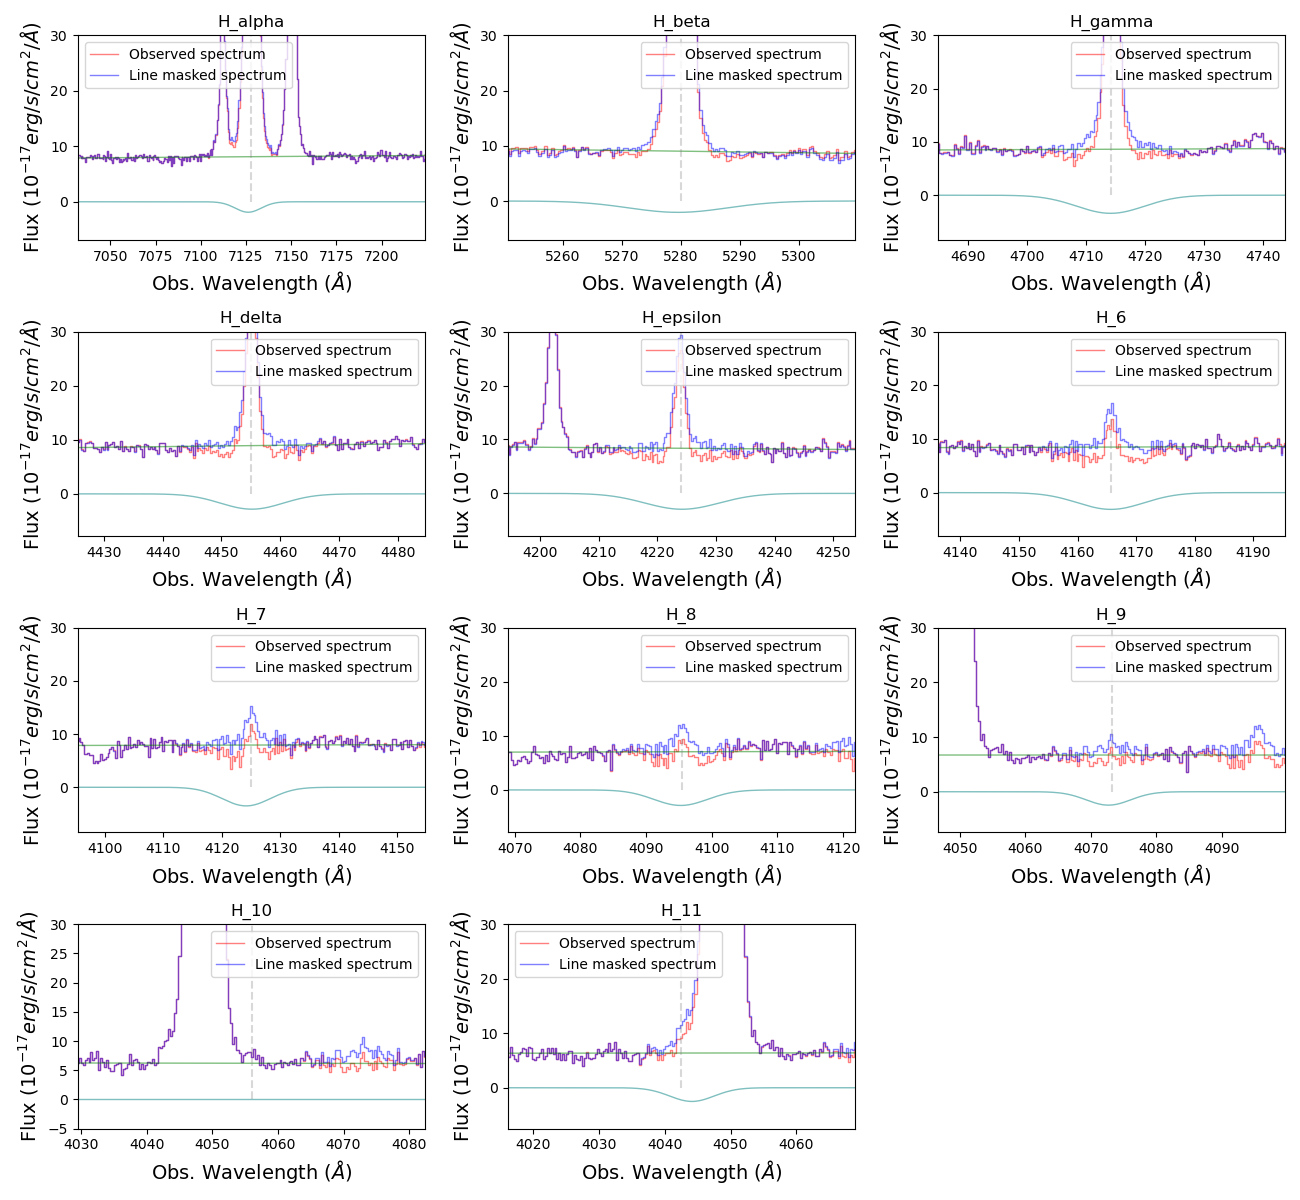

In [3]:
J0328_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/',
    'FILES': ['no_very_flats/J0328_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0328_TWILIGHT_tellcorr.fits'],
     'redshift': 0.086,
     'names':['J0328+0031'],
     'mass':9.8
}
J0328 = REDUC_LINES(J0328_SPECTRA)
# J0328.plot_spectra()
J0328.balmer_absorption(showplot=True)
# J0328.plot_new_spectra()

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/28-J0243/
New calculated redshift for no_very_flats,  z = 0.13436783505840433
New calculated redshift for twilight,  z = 0.13442118111394386
Plotting for J0243+0111


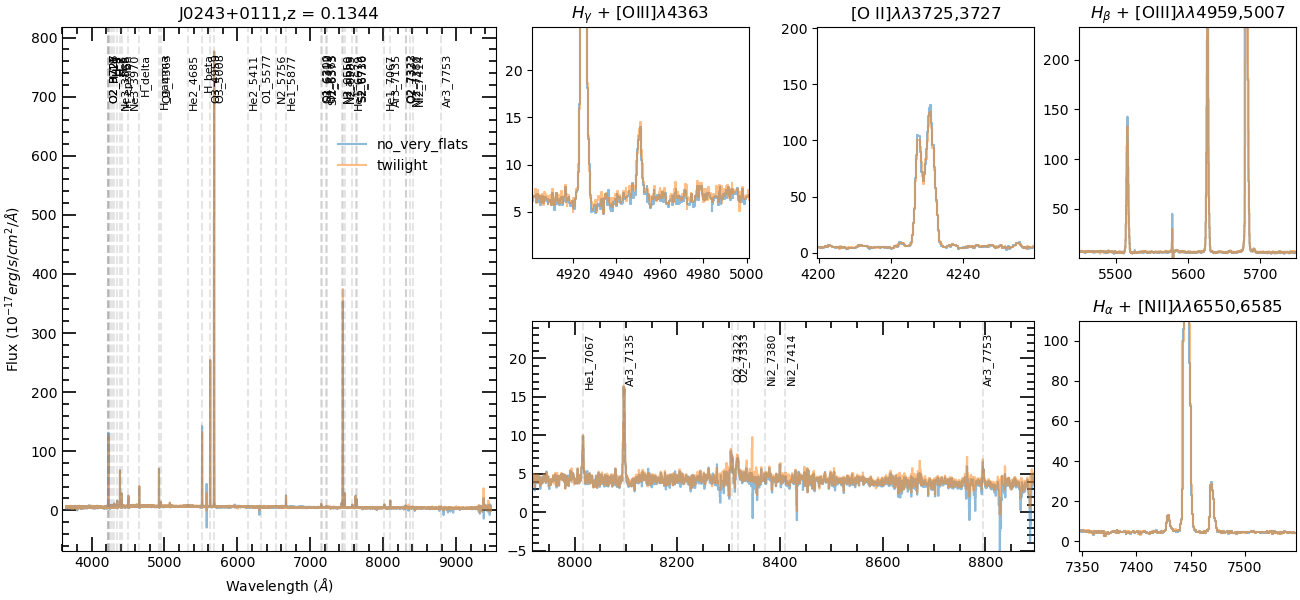

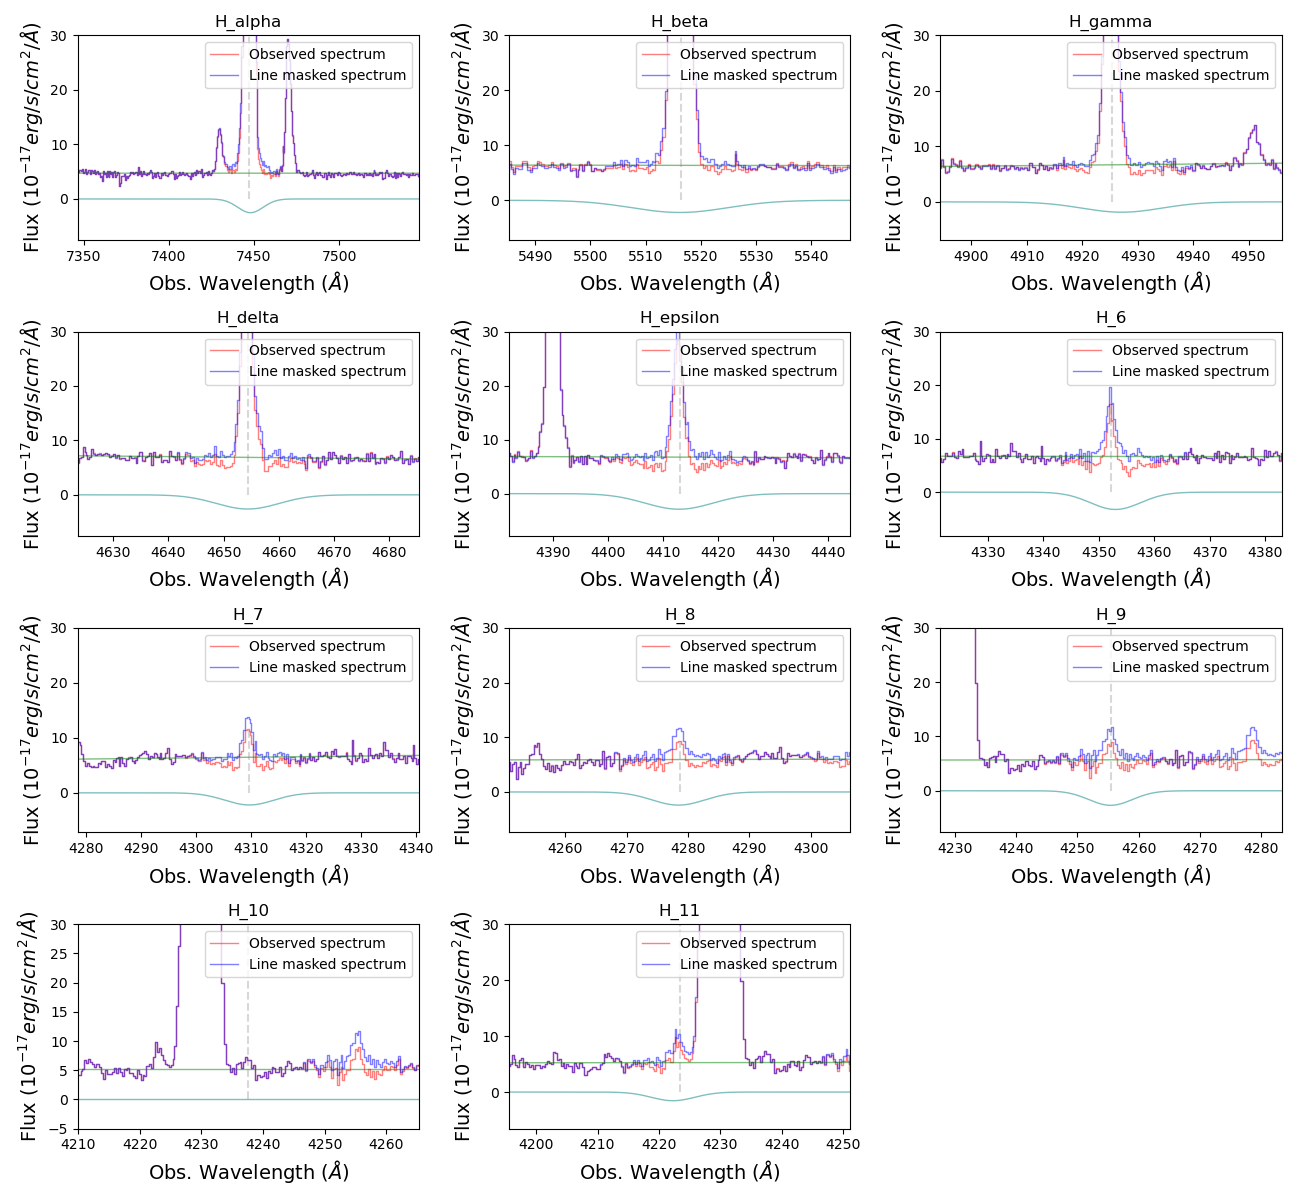

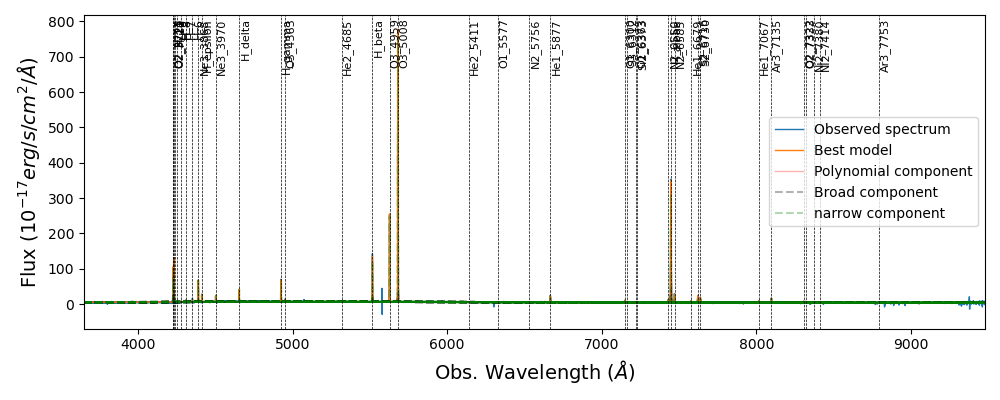

In [4]:
J0243_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/28-J0243/',
    'FILES': ['no_very_flats/J0243_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0243_TWILIGHT_tellcorr.fits'],
     'redshift': 0.134,
     'names':['J0243+0111'],
     'mass':9.7
}
J0243 = REDUC_LINES(J0243_SPECTRA)
J0243.plot_spectra()
J0243.balmer_absorption(showplot=True)
# J0243.plot_new_spectra()
fit = J0243.fit_spectra('normal', nfev=1000, show_Plot=True)

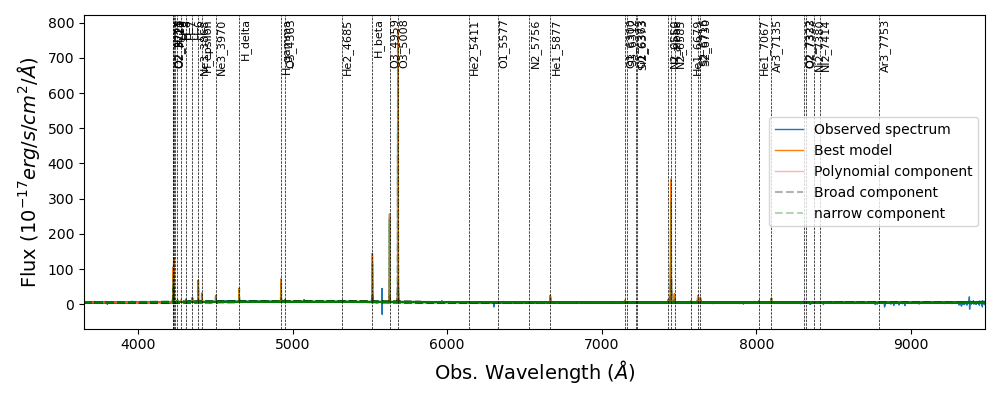

In [5]:
fit2 = J0243.fit_spectra('corrected', nfev=1000, show_Plot=True)

Modeling spectra


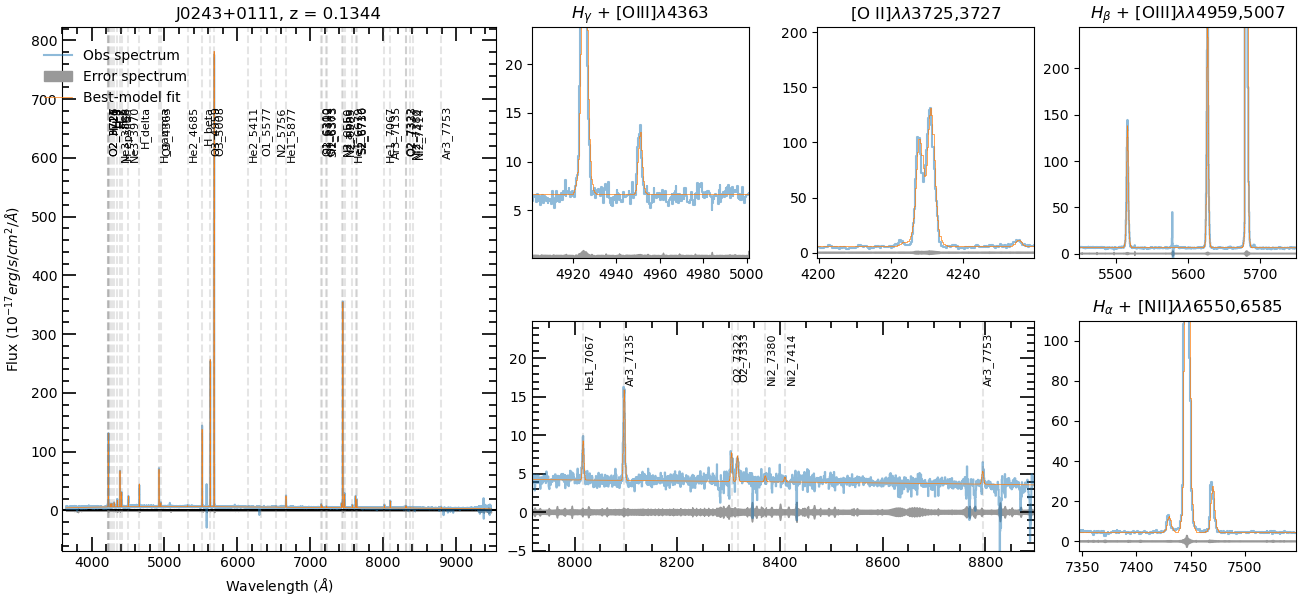

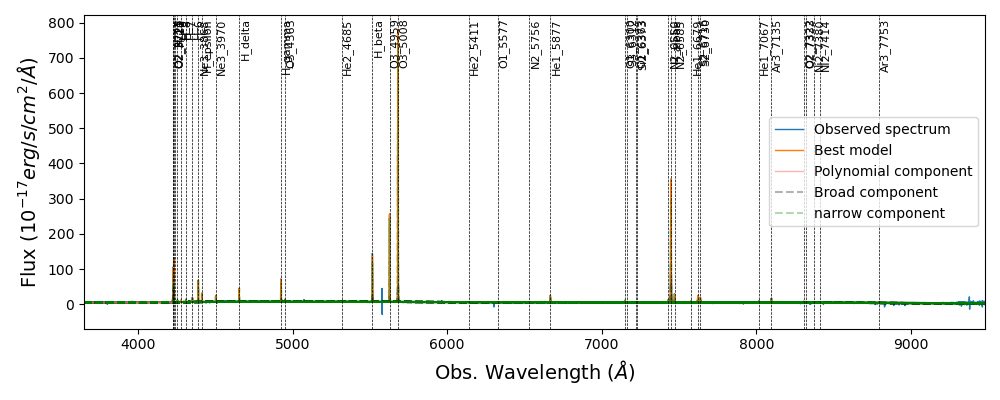

In [6]:
J0243.plot_fit('corrected', show_fit=True, nfev=1000)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/38-J0404/
New calculated redshift for no_very_flats,  z = 0.06580612935062868
New calculated redshift for twilight,  z = 0.06573682948807902


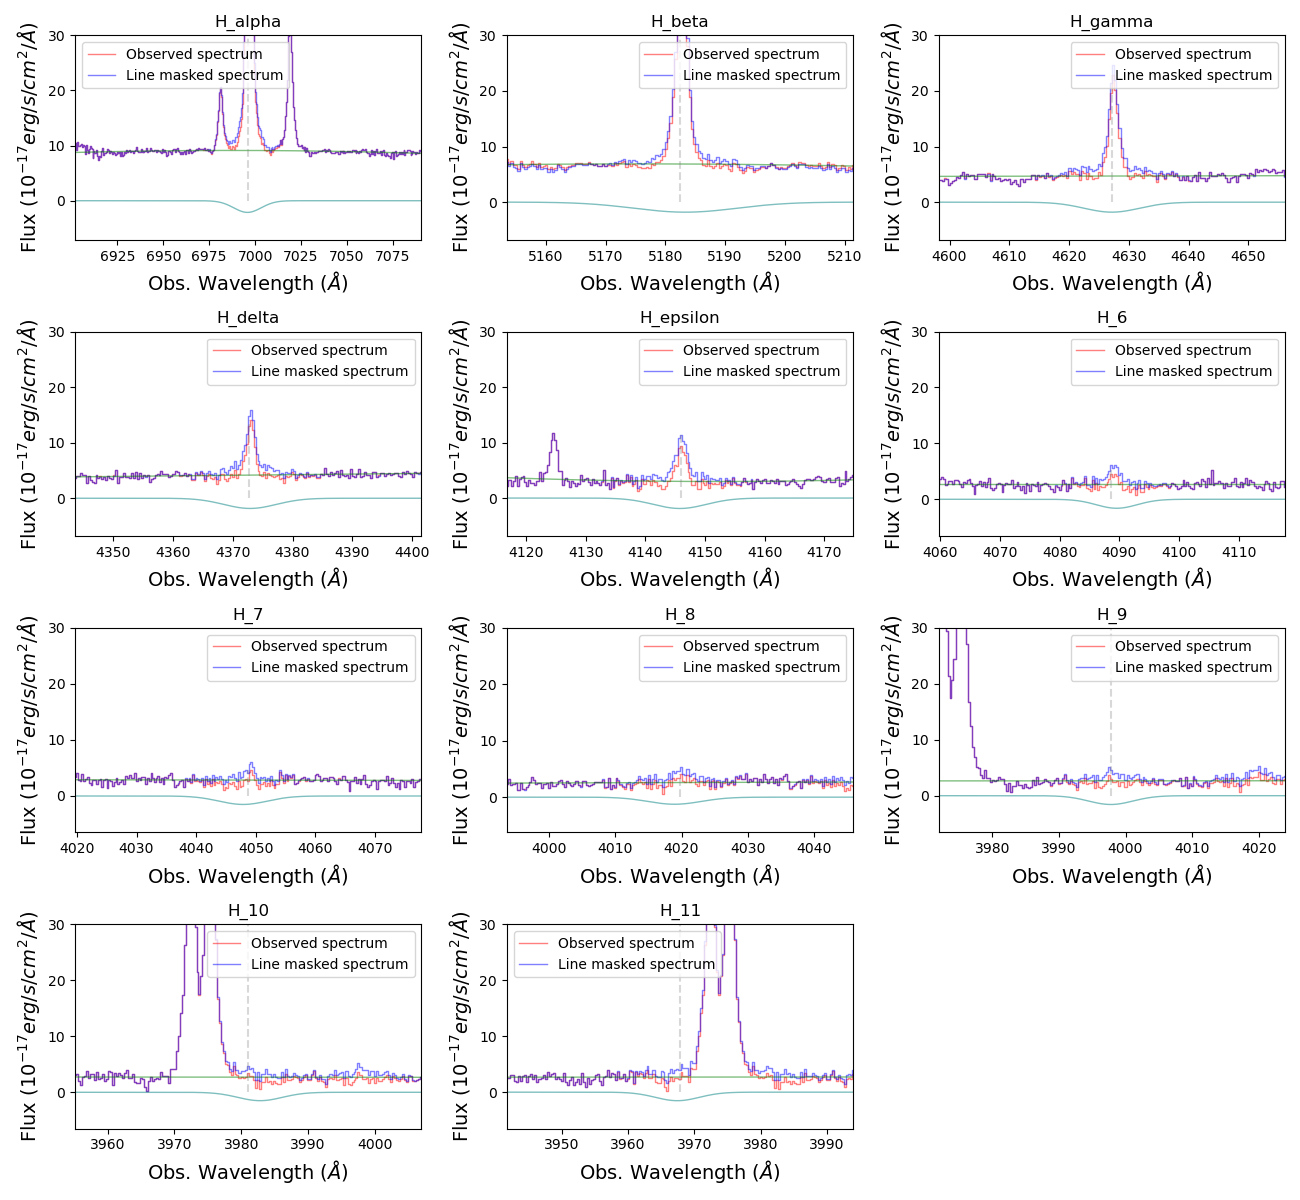

In [101]:
J0404_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/38-J0404/',
    'FILES': ['no_very_flats/J0404_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0404_TWILIGHT_tellcorr.fits'],
     'redshift': 0.066,
     'names':['J0404+0538'],
     'mass':10.2
}
J0404 = REDUC_LINES(J0404_SPECTRA)
# J0404.plot_spectra()
J0404.balmer_absorption(showplot=True)
# J0404.plot_new_spectra()

/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_4152/2036430123.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  H= pd.read_csv(file, delim_whitespace=True, header=None, skiprows=2)
/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_4152/2036430123.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  H= pd.read_csv(file, delim_whitespace=True, header=None, skiprows=2)
/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_4152/2036430123.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  H= pd.read_csv(file, delim_whitespace=True, header=None, skiprows=2)
/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_4152/2036430123.py:6: FutureWarning: The 'delim_whitespace'

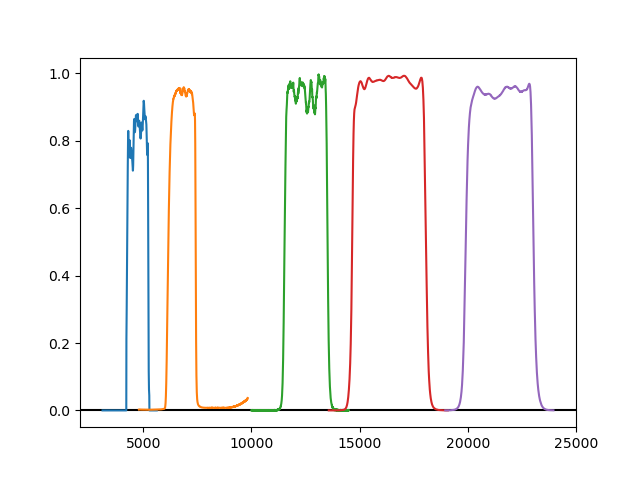

In [51]:
fig,ax=plt.subplots()
ax.axhline(0,color='k')

for band in ['g_lris','Rs_lris','mosfire_J','mosfire_H','mosfire_Ks']:
    file = f'/Users/javieratoro/Desktop/proyecto 2024-2/sed_fitting/filters/{band}.txt'
    H= pd.read_csv(file, delim_whitespace=True, header=None, skiprows=2)

    ax.plot(H[0],H[1])


In [63]:
band='mosfire_Ks'
file = f'/Users/javieratoro/Desktop/proyecto 2024-2/sed_fitting/filters/{band}.txt'
H= pd.read_csv(file, delim_whitespace=True, header=None, skiprows=2)
print(H)

            0         1
0     18960.0  0.000076
1     18965.0  0.000010
2     18970.0  0.000043
3     18975.0  0.000012
4     18980.0  0.000186
...       ...       ...
996   23940.0  0.000325
997   23945.0  0.000262
998   23950.0  0.000254
999   23955.0  0.000252
1000  23960.0  0.000224

[1001 rows x 2 columns]


/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_4152/3939304610.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  H= pd.read_csv(file, delim_whitespace=True, header=None, skiprows=2)
